# Initial Setup

In [45]:
# For better sorting of column names in some exercises.
!pip install natsort

In [46]:
# Initial imports.
from typing import Tuple, List

import numpy as np
import pandas as pd
import sklearn.model_selection as skm
import sklearn.linear_model as skl

from natsort import natsorted
from functools import partial
from ISLP import load_data
from l0bnb import fit_path

from matplotlib.pyplot import subplots
from matplotlib import pyplot as plt
from statsmodels.api import OLS
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

from ISLP.models import ModelSpec as MS
from ISLP.models import (
    Stepwise ,
    sklearn_selected ,
    sklearn_selection_path 
)

## Laboratory: Linear Models and Regularization Methods

### Subset Selection Methods

#### Forward Selection

In [47]:
Hitters = load_data("Hitters")

np.isnan(Hitters["Salary"]).sum()

59

In [48]:
Hitters: pd.DataFrame = Hitters.dropna()

# Show it.
Hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [49]:
def nCp(sigma2, estimator, X, Y):
    """
    Negative Cp statistic.
    """
    
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    
    return -(RSS + 2 * p * sigma2) / n

In [50]:
design = MS(Hitters.columns.drop("Salary")).fit(Hitters)

Y: np.array = np.array(Hitters["Salary"])
X: pd.DataFrame = design.transform(Hitters)

sigma2: float = OLS(Y,X).fit().scale

sigma2

99591.3561796822

In [51]:
neg_Cp = partial(nCp, sigma2)
neg_Cp?

Signature:      neg_Cp(estimator, X, Y)
Call signature: neg_Cp(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function nCp at 0x7f1605246830>, 99591.3561796822)
File:           /usr/lib/python3.10/functools.py
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.

In [52]:
strategy = Stepwise.first_peak(
    model_spec=design,
    direction="forward",
    max_terms=len(design.terms)
)

In [53]:
%%time

hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

CPU times: user 1.69 s, sys: 59 µs, total: 1.69 s
Wall time: 1.69 s


('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [54]:
%%time

hitters_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

CPU times: user 1.07 s, sys: 3.34 ms, total: 1.07 s
Wall time: 1.07 s


('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

#### Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [55]:
strategy = Stepwise.fixed_steps(
    design,
    len(design.terms),
    direction='forward'
)

full_path = sklearn_selection_path(OLS, strategy)
full_path

sklearn_selection_path(model_type=<class 'statsmodels.regression.linear_model.OLS'>,
                       strategy=Strategy(initial_state=(), candidate_states=<bound method Stepwise.candidate_states of <ISLP.models.strategy.Stepwise object at 0x7f1604fec490>>, build_submodel=<bound method ModelSpec.build_submodel of ModelSpec(terms=Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object'))>, check_finished=functools.partial(<function fixed_steps at 0x7f162d990b80>, 19), postprocess=functools.partial(<function _postprocess_fixed_steps at 0x7f162d990ca0>, 19)))

In [56]:
%%time

full_path.fit(Hitters, Y)
Yhat_in: np.ndarray = full_path.predict(Hitters)
Yhat_in.shape

CPU times: user 1.04 s, sys: 0 ns, total: 1.04 s
Wall time: 1.04 s


(263, 20)

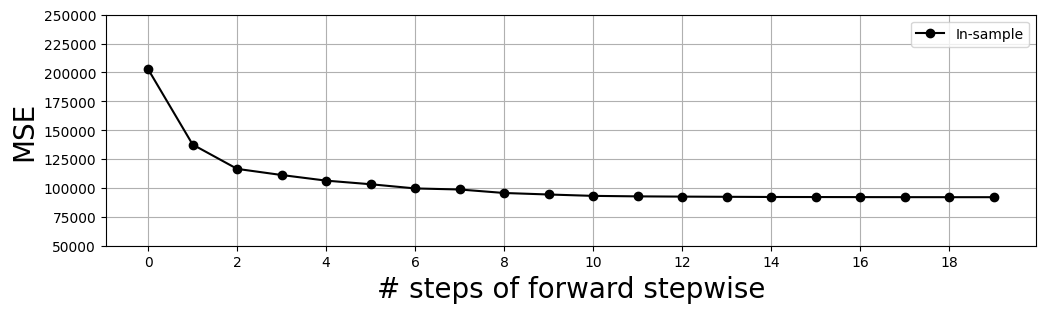

In [57]:
mse_fig, ax = subplots(figsize=(12, 3))

insample_mse: np.ndarray = ((Yhat_in - Y[:, None]) ** 2).mean(0)
n_steps: int = insample_mse.shape[0]

ax.plot(
    np.arange(n_steps),
    insample_mse,
    marker="o",
    color="k",  # color black
    label="In-sample"
)
ax.set_ylabel("MSE", fontsize=20)
ax.set_xlabel("# steps of forward stepwise", fontsize=20)
ax.set_xticks(np.arange(n_steps))
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.grid()
ax.set_ylim([50000, 250000]);

In [58]:
%%time

K: int = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv: np.ndarray = skm.cross_val_predict (full_path, Hitters, Y, cv=kfold)

Yhat_cv.shape

CPU times: user 5.08 s, sys: 217 µs, total: 5.08 s
Wall time: 5.08 s


(263, 20)

In [59]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):

    errors = (Yhat_cv[test_idx] - Y[test_idx, None])**2
    
    # Column means.
    cv_mse.append(errors.mean(0))  

cv_mse = np.array(cv_mse).T

cv_mse.shape

(20, 5)

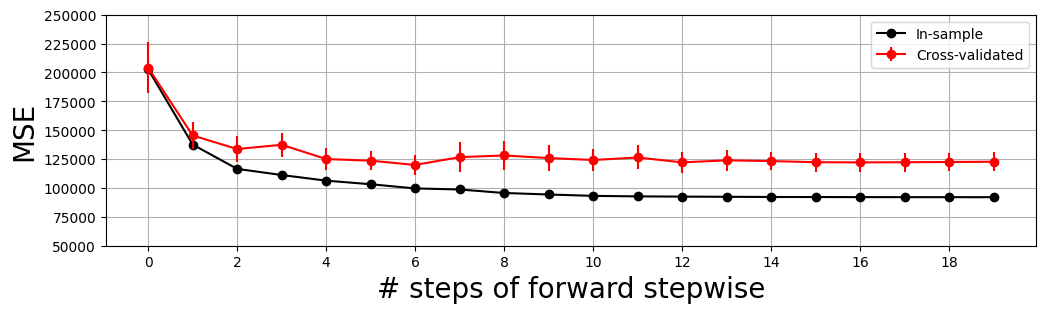

In [60]:
ax.errorbar(
    np.arange(n_steps),
    cv_mse.mean(axis=1),
    cv_mse.std(axis=1) / np.sqrt(K),
    label="Cross-validated",
    color="red",
    marker="o"
)

ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

In [61]:
validation = skm.ShuffleSplit(
    n_splits=1, test_size=0.2, random_state=0
)

for train_idx, test_idx in validation.split(Y):
    
    full_path.fit(Hitters.iloc[train_idx], Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx, None])**2
    
    validation_mse = errors.mean(0)

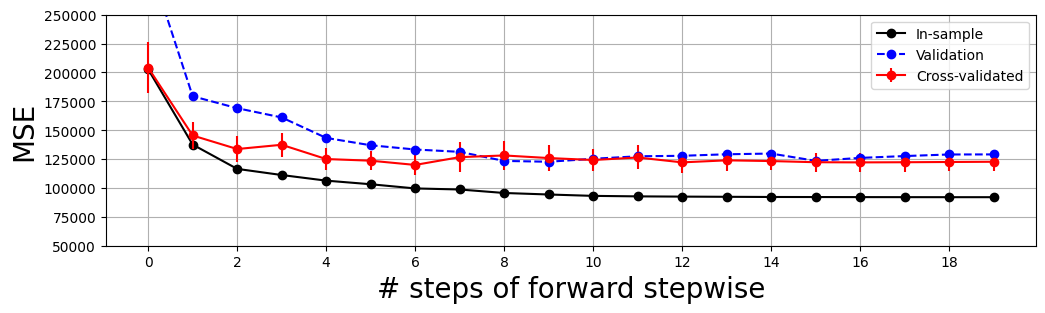

In [62]:
ax.plot(
    np.arange(n_steps), 
    validation_mse, 
    marker="o",
    color="blue",
    linestyle="--", # color blue, broken line
    label="Validation")

ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

#### Best Subset Selection

In [63]:
D = design.fit_transform(Hitters)
D = D.drop("intercept", axis=1)
X = np.asarray(D)

X.shape

(263, 19)

In [64]:
%%time

path = fit_path(X, Y, max_nonzeros=X.shape[1])
path[3]

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2


Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19
CPU times: user 3min 24s, sys: 43.5 ms, total: 3min 24s
Wall time: 4.28 s


{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555505,
 'lambda_0': 0.011416248027450187,
 'M': 0.5829861733382012,
 'Time_exceeded': False}

### Ridge Regression and the Lasso

#### Ridge Regression

In [65]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [66]:
Xs = X - X.mean(axis=0)[None, :]
X_scale = X.std(axis=0)
Xs = Xs / X_scale[None,:]

print(f">>> Scsled data shape: {Xs.shape}")

lambdas = 10 ** np.linspace(8, -2, 100) / Y.std() 
soln_array = skl.ElasticNet.path(X=Xs, y=Y, l1_ratio=0., alphas=lambdas)[1]

print(f">>> Number of lambdas: {lambdas.shape[0]}")
print(f">>> Solution array shape: {soln_array.shape}")

>>> Scsled data shape: (263, 19)
>>> Number of lambdas: 100
>>> Solution array shape: (19, 100)


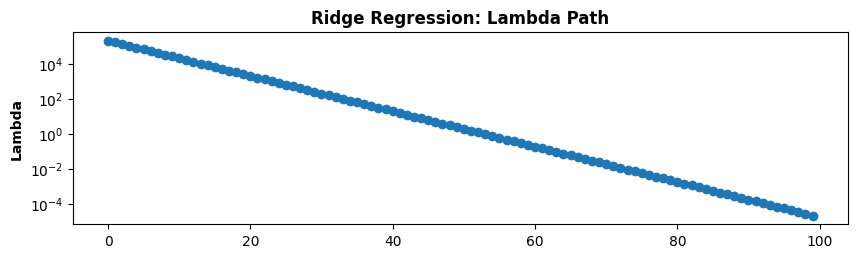

In [67]:
plt.figure(figsize=(10, 2.5))
plt.plot(lambdas, marker="o")
plt.ylabel("Lambda", weight="bold")
plt.title("Ridge Regression: Lambda Path", weight="bold")
plt.yscale("log");

In [68]:
soln_path: pd.DataFrame = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas))
soln_path.index.name = "negative log(lambda)"

# Show the solution path.
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


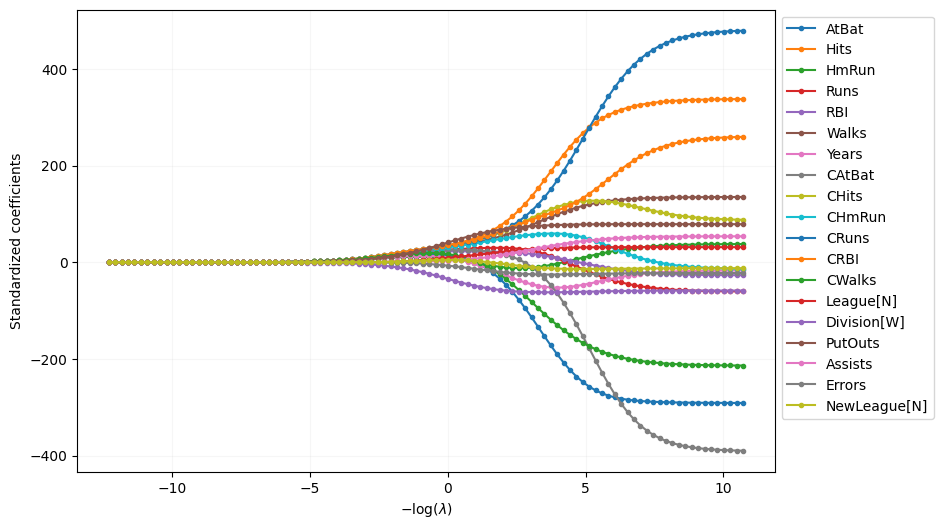

In [69]:
path_fig, ax = subplots(figsize=(9, 6)) 
soln_path.plot(ax=ax, legend=False, marker=".")
ax.set_xlabel("$-\log(\lambda)$")
ax.set_ylabel("Standardized coefficients") 

# Set legend ouside plot.
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.grid(alpha=0.10);

In [70]:
soln_path2 = soln_path.copy()
soln_path2.index = lambdas
soln_path2.index.name = "lambda"
soln_path2

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
lambda,,,,,,,,,,,,,,,,,,,
222093.790899,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
176005.531118,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
139481.373426,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
110536.603079,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
87598.367583,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.000056,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
0.000045,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
0.000035,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


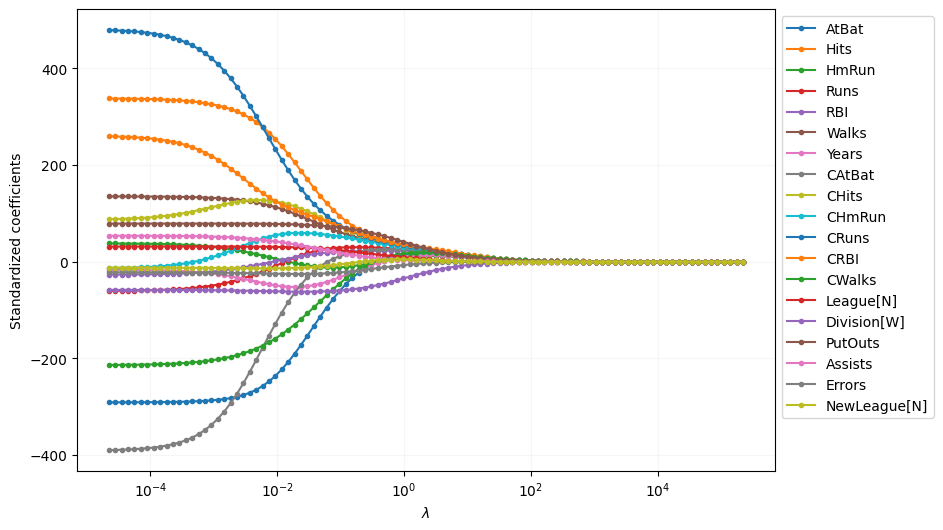

In [71]:
path_fig, ax = subplots(figsize=(9, 6)) 
soln_path2.plot(ax=ax, legend=False, marker=".")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel("Standardized coefficients") 

# Set legend ouside plot.
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.grid(alpha=0.10);
ax.set_xscale("log")

In [72]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(
    steps=[
        ("scaler", scaler), 
        ("ridge", ridge)
    ]
) 

pipe.fit(X, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.2437476613348855, l1_ratio=0))])

#### Estimating Test Error of Ridge Regression

## Exercises

### Ancillar Functions

In [73]:
def adjust_linear_model(
        dfX: pd.DataFrame, 
        dfY: pd.DataFrame
    ) -> Tuple[OLS, float, float, float, float]:
    """
    Adjust a linear model with all predictors.
    """
    
    linear_model = OLS(endog=dfY, exog=dfX).fit()

    return linear_model, linear_model.ssr, linear_model.rsquared, linear_model.bic, linear_model.aic


def forward_stepwise_selection(
        dfX: pd.DataFrame, 
        dfY: pd.DataFrame
    ) -> Tuple[List[int], List[float], List[float], List[float], List[float], List[float], List[OLS]]:
    """
    Forward stepwise selection.
    """
    
    print(">>> Starting forward stepwise selection...")

    # Initially all predictor are available.
    all_features: List[str] = dfX.columns.to_list()
    available_features: List[str] = dfX.columns.to_list()
    used_features: List[str] = []

    # Initialize some metrics to be used as a function of the number of used features.
    n_features: List[int] = []
    rss_list: List[float] = []
    r2_list: List[float] = []
    bic_list: List[float] = []
    aic_list: List[float] = []
    cp_list: List[float] = []
    best_models: List[OLS] = []

    # Initialize best Cp as very low.
    best_cp: float = -np.inf

    while len(used_features) < len(all_features):

        # Loop over all predictors.
        for feature in available_features:
            
            # If feature not already used.
            if feature not in used_features:

                # Candidates to test.
                tested_features: List[str] = used_features + [feature]

                print(f">>> Testing features: {tested_features}")

                # Fit model with current feature.
                model, rss, r2, bic, aic = adjust_linear_model(dfX[tested_features], dfY)

                # Calculate cp.
                cp: float = neg_Cp(model, dfX[tested_features], dfY["Y"])

                print(f"\t* metrics: CP={cp:.2f} (bestCP={best_cp:.2f}), RSS={rss:.2f}, R2={r2:.2f}, BIC={bic:.2f}, AIC={aic:.2f}")

                # Verify if the model is better according to Cp.
                if cp > best_cp:

                    # Update best metrics.
                    best_cp: float = cp
                    best_rss: float = rss
                    best_r2: float = r2
                    best_bic: float = bic
                    best_aic: float = aic

                    # Update best feature.
                    best_feature: str = feature

                    # Best model.
                    best_model: OLS = model

        # Update lists.
        used_features.append(best_feature)
        n_features.append(len(used_features))
        rss_list.append(best_rss)
        r2_list.append(best_r2)
        bic_list.append(best_bic)
        aic_list.append(best_aic)
        cp_list.append(best_cp)
        available_features.remove(best_feature)
        best_models.append(best_model)

        print(f"\t* Diagnostic: used features: {used_features}, Cp: {best_cp:.2f}, RSS: {best_rss:.2f}, R2: {best_r2:.2f}")

        # Reset best Cp for next round.
        best_cp = -np.inf

    print("\n>>> Done!")    

    return n_features, rss_list, r2_list, bic_list, aic_list, cp_list, best_models


def backward_stepwise_selection(
        dfX: pd.DataFrame, 
        dfY: pd.DataFrame
    ) -> Tuple[List[int], List[float], List[float], List[float], List[float], List[float], List[OLS]]:
    """
    Backward stepwise selection.
    """
    
    # Skeleton for backward stepwise selection.
    all_features: List[str] = dfX.columns.to_list()
    tested_features: List[str] = all_features.copy()
    candidates: List[str] = all_features.copy()

    # Initialize some metrics to be used as a function of the number of used features.
    n_features: List[int] = []
    rss_list: List[float] = []
    r2_list: List[float] = []
    bic_list: List[float] = []
    aic_list: List[float] = []
    cp_list: List[float] = []
    best_models: List[OLS] = []

    # Adjust linear model with all predictors.
    model, rss, r2, bic, aic = adjust_linear_model(dfX, dfY)

    # Calculate cp.
    cp: float = neg_Cp(model, dfX[tested_features], dfY["Y"])    

    n_features.append(len(all_features))
    rss_list.append(rss)
    r2_list.append(r2)
    bic_list.append(bic)
    aic_list.append(aic)
    cp_list.append(cp)
    best_models.append(model)

    # Initialize best Cp as very low.
    best_cp: float = -np.inf

    while len(candidates) > 1:

        print(f">>> Candidates to remove: {candidates}")

        # Loop over candidates to be removed.
        for candidate in all_features:

            # Is this a valid candidate?
            if candidate in candidates:

                # Features to be tested.
                tested_features = natsorted(list(set(candidates) - set([candidate])))

                print(f"\t* Exclude {candidate}:")

                # Adjust model and calculate metrics.
                model, rss, r2, bic, aic = adjust_linear_model(dfX[tested_features], dfY)

                # Calculate cp.
                cp: float = neg_Cp(model, dfX[tested_features], dfY["Y"])

                print(f"\t\t* metrics: CP={cp:.2f} (bestCP={best_cp:.2f}), RSS={rss:.2f}, R2={r2:.2f}, BIC={bic:.2f}, AIC={aic:.2f}")

                # Verify if the model is better according to Cp.
                if cp > best_cp:

                    # Update best metrics.
                    best_cp: float = cp
                    best_rss: float = rss
                    best_r2: float = r2
                    best_bic: float = bic
                    best_aic: float = aic

                    # Update best feature.
                    removed_feature: str = candidate
                    used_features: List[str] = tested_features

                    # Best model.
                    best_model: OLS = model
                
        # Select feature to be removed.
        print(f"\t* Removed feature: {removed_feature}")
        candidates.remove(removed_feature)    

        # Update lists.
        n_features.append(len(used_features))
        rss_list.append(best_rss)
        r2_list.append(best_r2)
        bic_list.append(best_bic)
        aic_list.append(best_aic)
        cp_list.append(best_cp)
        best_models.append(best_model)

        print(f"\t* Diagnostic:")
        print(f"\t\t* used features: {used_features}")
        print(f"\t\t* Cp: {best_cp:.2f}, RSS: {best_rss:.2f}, R2: {best_r2:.2f}")

        # Reset best Cp for next round.
        best_cp = -np.inf    

    return n_features, rss_list, r2_list, bic_list, aic_list, cp_list, best_models

### Conceptual

### Applied

#### 8

In [74]:
# a)

# Random predictors and noise.
X: np.ndarray = np.random.normal(loc=0.0, scale=1.0, size=(100, 1))
eps: np.ndarray = np.random.normal(loc=0.0, scale=1.0, size=(100, 1))

In [75]:
# b)

# Real parameters that generate data.
B0: float = 3
B1: float = 4
B2: float = 2
B3: float = 1

# Response.
Y: np.ndarray = B0 + B1*X + B2*(X**2) + B3*(X**3) + eps

# To dataframes.
dfY: pd.DataFrame = pd.DataFrame(Y, columns=["Y"])
dfY

,Y
0,1.326317
1,12.519549
2,7.157008
3,-3.102911
4,-0.326827
...,...
95,29.655018
96,4.301729
97,3.665473
98,5.723267


In [76]:
# c)

# As dataframe with intercept.
Features: np.ndarray = np.hstack([X**i for i in range(0, 11)])
dfX = pd.DataFrame(Features, columns=[f"X{i}" for i in range(0, 11)])
dfX

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,1.0,-0.320655,0.102820,-0.032970,1.057191e-02,-3.389939e-03,1.087002e-03,-3.485529e-04,1.117653e-04,-3.583814e-05,1.149169e-05
1,1.0,1.135269,1.288835,1.463173,1.661095e+00,1.885788e+00,2.140876e+00,2.430469e+00,2.759236e+00,3.132473e+00,3.556198e+00
2,1.0,0.745014,0.555046,0.413517,3.080763e-01,2.295212e-01,1.709965e-01,1.273949e-01,9.491098e-02,7.071003e-02,5.267998e-02
3,1.0,-1.747081,3.052292,-5.332602,9.316487e+00,-1.627666e+01,2.843664e+01,-4.968111e+01,8.679693e+01,-1.516413e+02,2.649296e+02
4,1.0,-1.260306,1.588372,-2.001835,2.522925e+00,-3.179658e+00,4.007343e+00,-5.050479e+00,6.365150e+00,-8.022038e+00,1.011023e+01
...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,2.112069,4.460837,9.421596,1.989906e+01,4.202820e+01,8.876646e+01,1.874809e+02,3.959727e+02,8.363217e+02,1.766369e+03
96,1.0,-0.013842,0.000192,-0.000003,3.670575e-08,-5.080630e-10,7.032360e-12,-9.733849e-14,1.347312e-15,-1.864883e-17,2.581280e-19
97,1.0,0.062445,0.003899,0.000244,1.520551e-05,9.495135e-07,5.929272e-08,3.702556e-09,2.312075e-10,1.443784e-11,9.015760e-13
98,1.0,0.273266,0.074675,0.020406,5.576289e-03,1.523813e-03,4.164069e-04,1.137900e-04,3.109500e-05,8.497219e-06,2.322005e-06


In [77]:
# Adjust a linear model with all predictors.
linear_model = OLS(endog=dfY, exog=dfX).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     511.6
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           4.43e-74
Time:                        14:52:22   Log-Likelihood:                -128.66
No. Observations:                 100   AIC:                             279.3
Df Residuals:                      89   BIC:                             308.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X0             3.5552      0.185     19.199      0.000       3.187       3.923
X1             4.7339      0.649      7.294      0.000       3.444       6.024
X2            -0.3973      1.374     -0.289      0.773      -3.127       2.332
X3            -1.1234      1.842     -0.610      0.543      -4.783       2.536
X4             3.7936      2.462      1.541      0.127      -1.099       8.686
X5             2.0029      1.636      1.224      0.224      -1.247       5.253
X6            -2.3782      1.588     -1.498      0.138      -5.533       0.776
X7            -0.6746      0.545     -1.237      0.219      -1.758       0.409
X8             0.6052      0.418      1.448      0.151      -0.226       1.436
X9             0.0707      0.058      1.222      0.225      -0.044       0.186
X10           -0.0524      0.038     -1.382      0.171      -0.128       0.023
==============================================================================
Omnibus:                        0.044   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.978   Jarque-Bera (JB):                0.022
Skew:                           0.022   Prob(JB):                        0.989
Kurtosis:                       2.941   Cond. No.                     2.87e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
# Model selection criterion scorer.
sigma2 = linear_model.scale
neg_Cp = partial(nCp , sigma2)

In [79]:
# Run forward stepwise selection.
n_features, rss_list, r2_list, bic_list, aic_list, cp_list, best_models = forward_stepwise_selection(dfX, dfY)

>>> Starting forward stepwise selection...
>>> Testing features: ['X0']
	* metrics: CP=-44.89 (bestCP=-inf), RSS=4487.70, R2=-0.00, BIC=668.79, AIC=666.18
>>> Testing features: ['X1']
	* metrics: CP=-33.49 (bestCP=-44.89), RSS=3347.76, R2=0.52, BIC=639.48, AIC=636.88
>>> Testing features: ['X2']
	* metrics: CP=-41.33 (bestCP=-33.49), RSS=4130.92, R2=0.40, BIC=660.50, AIC=657.90
>>> Testing features: ['X3']
	* metrics: CP=-31.46 (bestCP=-33.49), RSS=3144.29, R2=0.55, BIC=633.21, AIC=630.60
>>> Testing features: ['X4']
	* metrics: CP=-46.27 (bestCP=-31.46), RSS=4624.84, R2=0.33, BIC=671.80, AIC=669.19
>>> Testing features: ['X5']
	* metrics: CP=-39.20 (bestCP=-31.46), RSS=3918.23, R2=0.43, BIC=655.22, AIC=652.61
>>> Testing features: ['X6']
	* metrics: CP=-50.03 (bestCP=-31.46), RSS=5001.59, R2=0.28, BIC=679.63, AIC=677.02
>>> Testing features: ['X7']
	* metrics: CP=-44.41 (bestCP=-31.46), RSS=4439.28, R2=0.36, BIC=667.70, AIC=665.10
>>> Testing features: ['X8']
	* metrics: CP=-51.92 (be

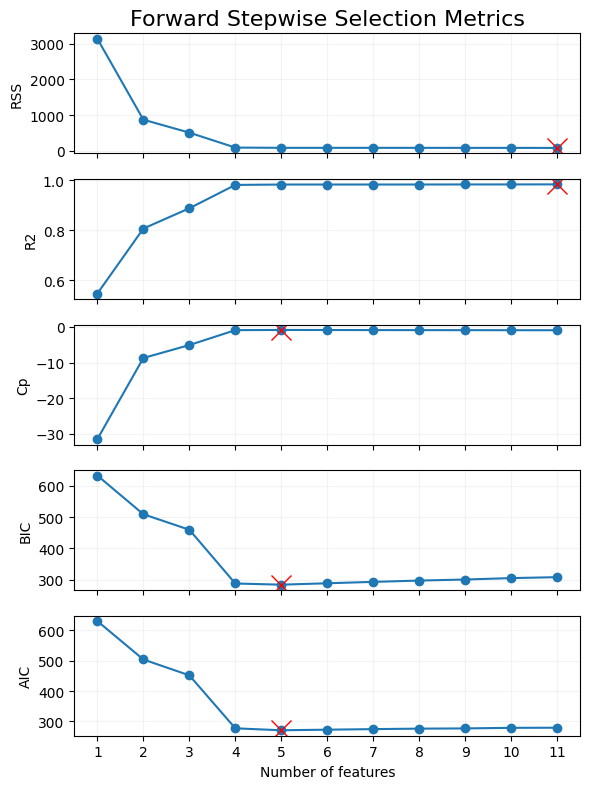

In [80]:
# Make figures.
fig, axs = subplots(5, 1, figsize=(6, 8), sharex=True)

# Plot metrics.
axs[0].plot(n_features, rss_list, marker="o")
axs[0].set_ylabel("RSS")
axs[1].plot(n_features, r2_list, marker="o")
axs[1].set_ylabel("R2")
axs[2].plot(n_features, cp_list, marker="o")
axs[2].set_ylabel("Cp")
axs[3].plot(n_features, bic_list, marker="o")
axs[3].set_ylabel("BIC")
axs[4].plot(n_features, aic_list, marker="o")
axs[4].set_ylabel("AIC")
axs[4].set_xlabel("Number of features")

# Plot minimum RSS as a red cross.
min_rss_idx = np.argmin(rss_list)
axs[0].plot(n_features[min_rss_idx], rss_list[min_rss_idx], marker="x", color="red", markersize=15)

# Plot maximum R2 as a red cross.
max_r2_idx = np.argmax(r2_list)
axs[1].plot(n_features[max_r2_idx], r2_list[max_r2_idx], marker="x", color="red", markersize=15)

# Plot maximum cp as a red cross.
max_cp_idx = np.argmax(cp_list)
axs[2].plot(n_features[max_cp_idx], cp_list[max_cp_idx], marker="x", color="red", markersize=15)

# Plot minimum BIC as a red cross.
min_bic_idx = np.argmin(bic_list)
axs[3].plot(n_features[min_bic_idx], bic_list[min_bic_idx], marker="x", color="red", markersize=15)

# Plot minimum AIC as a red cross.
min_aic_idx = np.argmin(aic_list)
axs[4].plot(n_features[min_aic_idx], aic_list[min_aic_idx], marker="x", color="red", markersize=15)

# X labels.
axs[4].set_xticks(n_features)

# Set grid for all axes.
for ax in axs:
    ax.grid(alpha=0.15)

# Title.
axs[0].set_title("Forward Stepwise Selection Metrics", fontsize=16)

plt.tight_layout()

In [81]:
# Expected coefficients.
df_compare_forward: pd.DataFrame = pd.DataFrame({
    "true": [B0, B1, B2, B3] + [0.0]*7
}, index=[f"X{i}" for i in range(0, 11)])

# Adjusted coefficients of the best model according to Cp, BIC, AIC, and R2.
df_cp: pd.DataFrame = best_models[max_cp_idx].params.to_frame(name="forward_cp")
df_bic: pd.DataFrame = best_models[min_bic_idx].params.to_frame(name="forward_bic")
df_aic: pd.DataFrame = best_models[min_aic_idx].params.to_frame(name="forward_aic")
df_r2: pd.DataFrame = best_models[max_r2_idx].params.to_frame(name="forward_r2")

# Join all dataframes.
df_compare_forward = df_compare_forward.join(df_cp, how="outer")
df_compare_forward = df_compare_forward.join(df_bic, how="outer")
df_compare_forward = df_compare_forward.join(df_aic, how="outer")  
df_compare_forward = df_compare_forward.join(df_r2, how="outer")

# Reduce float precision.
df_compare_forward = df_compare_forward.round(3)

# Better sorting of the index.
df_compare_forward = df_compare_forward.reindex(natsorted(df_compare_forward.index))

df_compare_forward

,true,forward_cp,forward_bic,forward_aic,forward_r2
X0,3.0,3.388,3.388,3.388,3.555
X1,4.0,4.205,4.205,4.205,4.734
X2,2.0,1.683,1.683,1.683,-0.397
X3,1.0,0.936,0.936,0.936,-1.123
X4,0.0,NaN,NaN,NaN,3.794
X5,0.0,NaN,NaN,NaN,2.003
X6,0.0,NaN,NaN,NaN,-2.378
X7,0.0,NaN,NaN,NaN,-0.675
X8,0.0,0.003,0.003,0.003,0.605
X9,0.0,NaN,NaN,NaN,0.071


In [82]:
# c)

# Run backward stepwise selection.
n_features, rss_list, r2_list, bic_list, aic_list, cp_list, best_models = backward_stepwise_selection(dfX, dfY)

>>> Candidates to remove: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']
	* Exclude X0:
		* metrics: CP=-4.12 (bestCP=-inf), RSS=394.56, R2=0.94, BIC=467.10, AIC=441.05
	* Exclude X1:
		* metrics: CP=-1.40 (bestCP=-4.12), RSS=122.61, R2=0.97, BIC=350.22, AIC=324.17
	* Exclude X2:
		* metrics: CP=-0.94 (bestCP=-1.40), RSS=76.81, R2=0.98, BIC=303.46, AIC=277.40
	* Exclude X3:
		* metrics: CP=-0.94 (bestCP=-0.94), RSS=77.06, R2=0.98, BIC=303.78, AIC=277.73
	* Exclude X4:
		* metrics: CP=-0.96 (bestCP=-0.94), RSS=78.79, R2=0.98, BIC=306.00, AIC=279.94
	* Exclude X5:
		* metrics: CP=-0.95 (bestCP=-0.94), RSS=78.03, R2=0.98, BIC=305.03, AIC=278.98
	* Exclude X6:
		* metrics: CP=-0.96 (bestCP=-0.94), RSS=78.67, R2=0.98, BIC=305.85, AIC=279.80
	* Exclude X7:
		* metrics: CP=-0.95 (bestCP=-0.94), RSS=78.06, R2=0.98, BIC=305.07, AIC=279.02
	* Exclude X8:
		* metrics: CP=-0.96 (bestCP=-0.94), RSS=78.55, R2=0.98, BIC=305.69, AIC=279.64
	* Exclude X9:
		* metrics: CP=-0.95 (bes

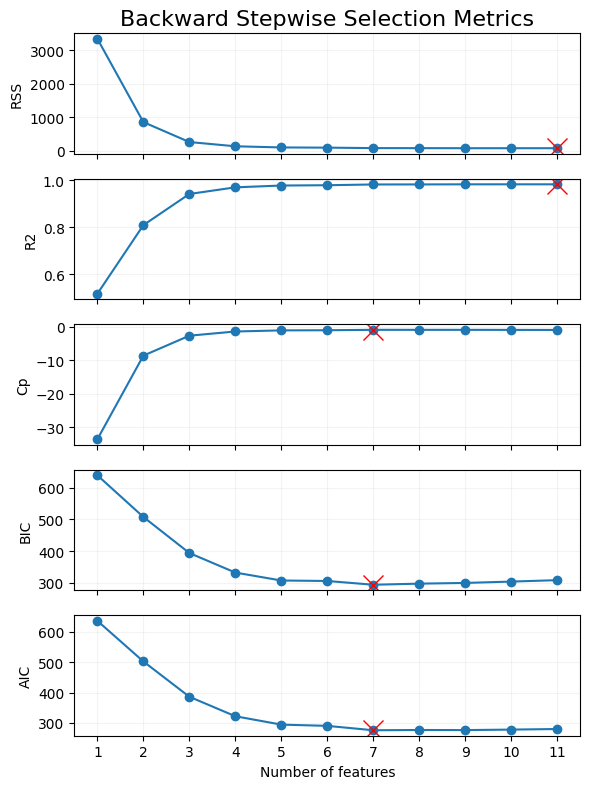

In [83]:
# Make figures.
fig, axs = subplots(5, 1, figsize=(6, 8), sharex=True)

# Plot metrics.
axs[0].plot(n_features, rss_list, marker="o")
axs[0].set_ylabel("RSS")
axs[1].plot(n_features, r2_list, marker="o")
axs[1].set_ylabel("R2")
axs[2].plot(n_features, cp_list, marker="o")
axs[2].set_ylabel("Cp")
axs[3].plot(n_features, bic_list, marker="o")
axs[3].set_ylabel("BIC")
axs[4].plot(n_features, aic_list, marker="o")
axs[4].set_ylabel("AIC")
axs[4].set_xlabel("Number of features")

# Plot minimum RSS as a red cross.
min_rss_idx = np.argmin(rss_list)
axs[0].plot(n_features[min_rss_idx], rss_list[min_rss_idx], marker="x", color="red", markersize=15)

# Plot maximum R2 as a red cross.
max_r2_idx = np.argmax(r2_list)
axs[1].plot(n_features[max_r2_idx], r2_list[max_r2_idx], marker="x", color="red", markersize=15)

# Plot maximum cp as a red cross.
max_cp_idx = np.argmax(cp_list)
axs[2].plot(n_features[max_cp_idx], cp_list[max_cp_idx], marker="x", color="red", markersize=15)

# Plot minimum BIC as a red cross.
min_bic_idx = np.argmin(bic_list)
axs[3].plot(n_features[min_bic_idx], bic_list[min_bic_idx], marker="x", color="red", markersize=15)

# Plot minimum AIC as a red cross.
min_aic_idx = np.argmin(aic_list)
axs[4].plot(n_features[min_aic_idx], aic_list[min_aic_idx], marker="x", color="red", markersize=15)

# X labels.
axs[4].set_xticks(n_features)

# Set grid for all axes.
for ax in axs:
    ax.grid(alpha=0.15)

# Title.
axs[0].set_title("Backward Stepwise Selection Metrics", fontsize=16)

plt.tight_layout()

In [84]:
# Initialize.
df_compare_backward: pd.DataFrame = pd.DataFrame({
    "true": [B0, B1, B2, B3] + [0.0]*7
}, index=[f"X{i}" for i in range(0, 11)])

# Adjusted coefficients of the best model according to Cp, BIC, AIC, and R2.
df_cp: pd.DataFrame = best_models[max_cp_idx].params.to_frame(name="backward_cp")
df_bic: pd.DataFrame = best_models[min_bic_idx].params.to_frame(name="backward_bic")
df_aic: pd.DataFrame = best_models[min_aic_idx].params.to_frame(name="backward_aic")
df_r2: pd.DataFrame = best_models[max_r2_idx].params.to_frame(name="backward_r2")

# Join all dataframes.
df_compare_backward = df_compare_backward.join(df_cp, how="outer")
df_compare_backward = df_compare_backward.join(df_bic, how="outer")
df_compare_backward = df_compare_backward.join(df_aic, how="outer")  
df_compare_backward = df_compare_backward.join(df_r2, how="outer")

# Reduce float precision.
df_compare_backward = df_compare_backward.round(3)

# Better sorting of the index.
df_compare_backward = df_compare_backward.reindex(natsorted(df_compare_backward.index))

# Show it.
df_compare_backward

,true,backward_cp,backward_bic,backward_aic,backward_r2
X0,3.0,3.615,3.615,3.615,3.555
X1,4.0,4.595,4.595,4.595,4.734
X2,2.0,NaN,NaN,NaN,-0.397
X3,1.0,NaN,NaN,NaN,-1.123
X4,0.0,1.895,1.895,1.895,3.794
X5,0.0,0.502,0.502,0.502,2.003
X6,0.0,-0.670,-0.670,-0.670,-2.378
X7,0.0,-0.068,-0.068,-0.068,-0.675
X8,0.0,0.074,0.074,0.074,0.605
X9,0.0,NaN,NaN,NaN,0.071


In [85]:
# Join results dataframes.
df_results: pd.DataFrame = pd.concat([
        df_compare_forward, 
        df_compare_backward.drop(columns=["true"])
    ], 
    axis=1
).T

# Show it.
df_results

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
true,3.000,4.000,2.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
forward_cp,3.388,4.205,1.683,0.936,NaN,NaN,NaN,NaN,0.003,NaN,NaN
forward_bic,3.388,4.205,1.683,0.936,NaN,NaN,NaN,NaN,0.003,NaN,NaN
forward_aic,3.388,4.205,1.683,0.936,NaN,NaN,NaN,NaN,0.003,NaN,NaN
forward_r2,3.555,4.734,-0.397,-1.123,3.794,2.003,-2.378,-0.675,0.605,0.071,-0.052
backward_cp,3.615,4.595,NaN,NaN,1.895,0.502,-0.670,-0.068,0.074,NaN,NaN
backward_bic,3.615,4.595,NaN,NaN,1.895,0.502,-0.670,-0.068,0.074,NaN,NaN
backward_aic,3.615,4.595,NaN,NaN,1.895,0.502,-0.670,-0.068,0.074,NaN,NaN
backward_r2,3.555,4.734,-0.397,-1.123,3.794,2.003,-2.378,-0.675,0.605,0.071,-0.052


In [86]:
%%time

# e)

# Exclude constant term.
X: np.array = np.asarray(dfX.drop(columns=["X0"]))
y: np.array = dfY["Y"].values

# Hyperparameters.
lambdas: np.array = 10 ** np.linspace(6, -5, 100) / y.std() 
K: int = 10
kfold = skm.KFold(K, random_state=0, shuffle=True)

# Lasso with cross-validation.
lassocv = skl.ElasticNetCV(l1_ratio=1.0, alphas=lambdas, cv=kfold)
scaler = StandardScaler(with_mean=True, with_std=True)
pipelinecv = Pipeline(steps=[("scaler", scaler), ("lassocv", lassocv)])

# Fit the models.
pipelinecv.fit(X, y)

# Show results.
tunned_lasso = pipelinecv.named_steps["lassocv"]
tunned_lasso

CPU times: user 213 ms, sys: 64 µs, total: 213 ms
Wall time: 212 ms


ElasticNetCV(alphas=array([1.49275399e+05, 1.15578520e+05, 8.94882509e+04, 6.92875027e+04,
       5.36467970e+04, 4.15367666e+04, 3.21604099e+04, 2.49006374e+04,
       1.92796592e+04, 1.49275399e+04, 1.15578520e+04, 8.94882509e+03,
       6.92875027e+03, 5.36467970e+03, 4.15367666e+03, 3.21604099e+03,
       2.49006374e+03, 1.92796592e+03, 1.49275399e+03, 1.15578520e+03,
       8.94882509e+02, 6.928750...
       1.92796592e-04, 1.49275399e-04, 1.15578520e-04, 8.94882509e-05,
       6.92875027e-05, 5.36467970e-05, 4.15367666e-05, 3.21604099e-05,
       2.49006374e-05, 1.92796592e-05, 1.49275399e-05, 1.15578520e-05,
       8.94882509e-06, 6.92875027e-06, 5.36467970e-06, 4.15367666e-06,
       3.21604099e-06, 2.49006374e-06, 1.92796592e-06, 1.49275399e-06]),
             cv=KFold(n_splits=10, random_state=0, shuffle=True), l1_ratio=1.0)

>>> Best lambda: 1.15579e-02
>>> Best CV MSE: 0.8956 +/- 0.1430


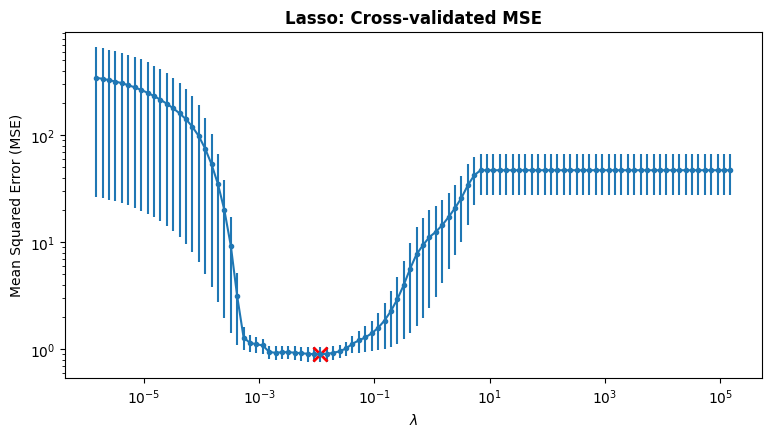

In [87]:
# Mean and error of the MSE path.
cv_mse: np.array = tunned_lasso.mse_path_.mean(axis=1)
cv_mse_err: np.array = tunned_lasso.mse_path_.std(1) / np.sqrt(K)

# Find better results.
best_idx: int = np.argmin(cv_mse)

print(f">>> Best lambda: {lambdas[best_idx]:.5e}")
print(f">>> Best CV MSE: {cv_mse[best_idx]:.4f} +/- {cv_mse_err[best_idx]:.4f}")

# Create figure.
path_fig, ax = subplots(figsize=(9, 4.5)) 

# Plot it.
ax.errorbar(
    lambdas, 
    cv_mse, 
    yerr=cv_mse_err,
    marker="."
)

# Plot better lambda as a red cross.
ax.plot(
    lambdas[best_idx],
    cv_mse[best_idx],
    marker="x",
    color="red",
    markersize=10,
    markeredgewidth=2
)

# Labels.
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel("Mean Squared Error (MSE)")
ax.set_title("Lasso: Cross-validated MSE", weight="bold");

In [88]:
# Lasso results.
new_row = pd.DataFrame(
    np.hstack([tunned_lasso.intercept_, tunned_lasso.coef_])[None, :], 
    columns=dfX.columns, 
    index=["lasso_cv"]
)

# Add lasso results to the results dataframe.
df_results = pd.concat([df_results, new_row], axis=0)

# Show it.
df_results

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
true,3.000000,4.000000,2.000000,1.000000,0.000000,0.000,0.000,0.000,0.000,0.000,0.000000
forward_cp,3.388000,4.205000,1.683000,0.936000,NaN,NaN,NaN,NaN,0.003,NaN,NaN
forward_bic,3.388000,4.205000,1.683000,0.936000,NaN,NaN,NaN,NaN,0.003,NaN,NaN
forward_aic,3.388000,4.205000,1.683000,0.936000,NaN,NaN,NaN,NaN,0.003,NaN,NaN
forward_r2,3.555000,4.734000,-0.397000,-1.123000,3.794000,2.003,-2.378,-0.675,0.605,0.071,-0.052000
backward_cp,3.615000,4.595000,NaN,NaN,1.895000,0.502,-0.670,-0.068,0.074,NaN,NaN
backward_bic,3.615000,4.595000,NaN,NaN,1.895000,0.502,-0.670,-0.068,0.074,NaN,NaN
backward_aic,3.615000,4.595000,NaN,NaN,1.895000,0.502,-0.670,-0.068,0.074,NaN,NaN
backward_r2,3.555000,4.734000,-0.397000,-1.123000,3.794000,2.003,-2.378,-0.675,0.605,0.071,-0.052000
lasso_cv,4.939182,3.874322,1.724879,2.350314,0.232077,0.000,0.000,0.000,0.000,0.000,0.263581
